In [1]:
# Create GAN for independent and identically distributed data

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import secrets

import keras 
class GAN:
    def __init__(self, seq_len=31, latent_dim = 5, key1_len = 5, key2_len = 5):
        
        
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.tapped_1 = np.array([2, 3, 4, 5])
        self.tapped_2 = np.array([3, 5])
        self.key1_len = key1_len
        self.key2_len = key2_len
        
        seed = secrets.randbits(128)
        self.rng = np.random.default_rng(seed)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        # print(self.P)
    
    def generate_real_samples(self, n_samples):
        key1 = self.rng.binomial(1, 0.5, (n_samples, self.key1_len))
        key2 = self.rng.binomial(1, 0.5, (n_samples, self.key2_len))
        print(list(zip(key1, key2)))
        X = np.array([[] for _ in range(n_samples)])
        # print(X.shape)
        for _ in range(self.seq_len):
            next_1 = np.bitwise_xor.reduce(key1[:, self.tapped_1 - 1], axis=1)
            next_2 = np.bitwise_xor.reduce(key2[:, self.tapped_2 - 1], axis=1)
            key1 = np.roll(key1, 1, axis=1)
            key2 = np.roll(key2, 1, axis=1)
            key1[:, 0] = next_1
            key2[:, 0] = next_2
            # print(next_1.shape, next_2.shape)
            X = np.append(X, (next_1 ^ next_2).reshape(-1, 1), axis=1)
            # print(X.shape)
        # X = np.array(X)
        X = X.reshape(n_samples, self.seq_len, 1)
            
            

            
        
        
        y = np.ones((n_samples, 1)) * 0.9
        return X, y
    
    def generate_fake_samples(self, n_samples):
        X = self.generator.predict(np.random.normal(0, 1, (n_samples, self.latent_dim)))
        y = np.zeros((n_samples, 1))
        return X, y
    
    def calculate_P(self, n_samples):
        X, _ = self.generate_fake_samples(n_samples)
        return np.mean(X, axis=0) 
    
    def build_generator(self):
        self.generator = keras.models.Sequential([
            keras.layers.Dense(self.seq_len * 200, input_shape=(self.latent_dim,)),
            keras.layers.LeakyReLU(alpha=0.2),
            keras.layers.Reshape((self.seq_len, 200)),
            # keras.layers.TimeDistributed(keras.layers.Dense(100)),
            keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
            # keras.layers.LSTM(100, return_sequences=True),
            # keras.layers.LSTM(100, return_sequences=True),
            # keras.layers.Dense(10, activation='relu'),
            
            keras.layers.Dense(1, activation='sigmoid'),
        ])
    def summarize_generator(self):
        self.generator.summary()

    def build_discriminator(self):
        self.discriminator = keras.models.Sequential([
            keras.layers.Bidirectional(keras.layers.LSTM(100, input_shape=(self.seq_len, 1), return_sequences=True)),
            # keras.layers.Dropout(0.5),
            # keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
            # keras.layers.Dropout(0.5),
            keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=False)),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
        self.discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    def summarize_discriminator(self):
        self.discriminator.summary()
    
    def build_gan(self):
        self.discriminator.trainable = False
        self.gan = keras.models.Sequential([
            self.generator,
            self.discriminator,
        ])
        self.gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam())
        
    def train(self, epochs = 10, batch_size = 64, data_size = 500):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        # total = data_size//batch_size
        total = 100000//batch_size
        train_data_x, train_data_y = self.generate_real_samples(data_size)
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator
            
            for k in range(total):
                print(k,"/",total,end="\r")
                idx = np.random.randint(0, data_size, batch_size//2)
                X_real, y_real = train_data_x[idx], train_data_y[idx]
                X_fake, y_fake = self.generate_fake_samples(batch_size//2)
                

                l1, ac1 = self.discriminator.train_on_batch(X_real, y_real)
                l2, ac2 = self.discriminator.train_on_batch(X_fake, y_fake)
                
                X_fake = np.random.normal(0, 1, (batch_size, self.latent_dim))
                y_fake = np.ones((batch_size, 1))
                l3 = self.gan.train_on_batch(X_fake, y_fake)
                
                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)
                
            # Show plots of the losses and accuracies
            # calc_p = self.calculate_P(100000)
            # print(calc_p)
            pred = self.generator.predict(np.random.normal(0, 1, (1, self.latent_dim)))
            print(pred)
            print(self.discriminator.predict(pred))
            # print("Loss:",np.mean(np.abs(calc_p - self.P)))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

2024-03-08 13:12:35.487203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 13:12:37.198183: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/TensorRT-8.4.0.6//lib:/usr/local/cuda-11.6/lib64:/usr/local/apps/python-3.10.2/lib:/usr/local/apps/cuDNN/8.4.0-cuda-11.6/lib
2024-03-08 13:12:37.198321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [2]:
gan = GAN()
gan.summarize_generator()
gan.summarize_discriminator()

# print(.shape)

/home2/shivam.sood/shivam_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home2/shivam.sood/shivam_env/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-03-08 13:12:41.023412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 13:12:41.787927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:local

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6200)           │        37,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 31, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 31, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31, 1)          │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,201 (1.06 MB)

 Trainable params: 278,201 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [3]:
print(gan.generate_real_samples(1)[0].shape)

(1, 10)


Iteration: 0


2024-03-01 15:38:40.955661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2024-03-01 15:38:46.105140: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x15452017f860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 15:38:46.105213: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-03-01 15:38:46.111538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-01 15:38:46.261447: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[[0.30652702]
 [0.45947805]
 [0.74303776]
 [0.56253576]
 [0.42497176]
 [0.3673692 ]
 [0.30928868]
 [0.41906363]
 [0.5756469 ]
 [0.74277717]]
47.8
50.59
51.25


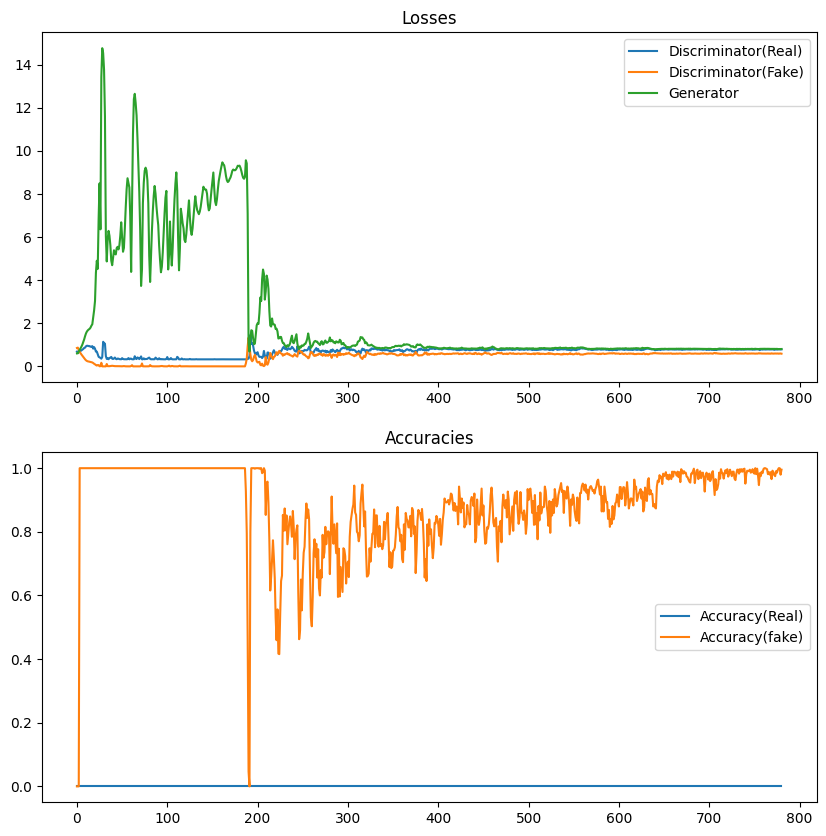

Iteration: 1
[[0.34247118]
 [0.6060632 ]
 [0.69936675]
 [0.5079531 ]
 [0.46544614]
 [0.36688593]
 [0.31303525]
 [0.452817  ]
 [0.6445741 ]
 [0.7411174 ]]
44.55
49.79
49.77


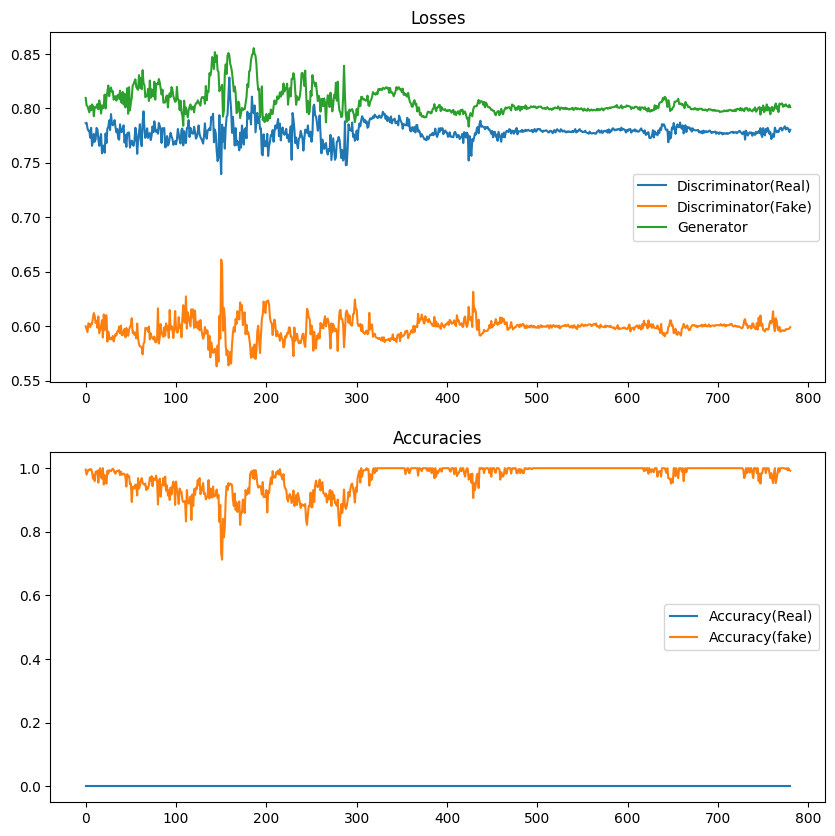

Iteration: 2
[[0.2793588 ]
 [0.5017161 ]
 [0.6348755 ]
 [0.5267796 ]
 [0.36876482]
 [0.27600163]
 [0.29494527]
 [0.4621685 ]
 [0.5179766 ]
 [0.66183305]]
46.65
49.79
49.28


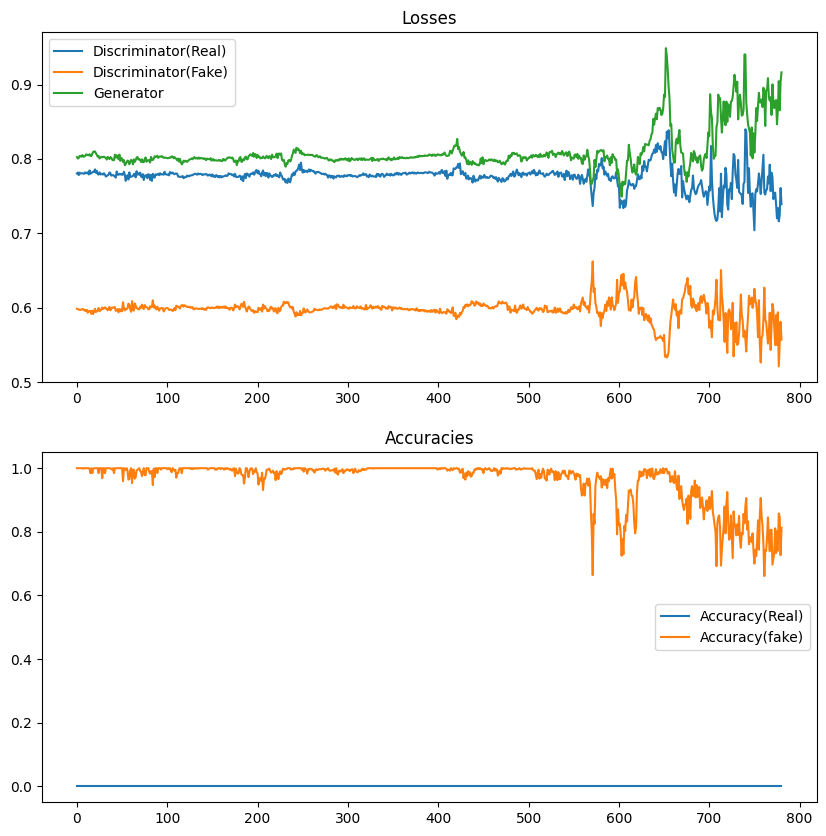

Iteration: 3
[[0.37127542]
 [0.5390366 ]
 [0.61784166]
 [0.6603432 ]
 [0.42388645]
 [0.29800838]
 [0.36221603]
 [0.5848414 ]
 [0.5736499 ]
 [0.8176997 ]]
46.37
51.23
49.77


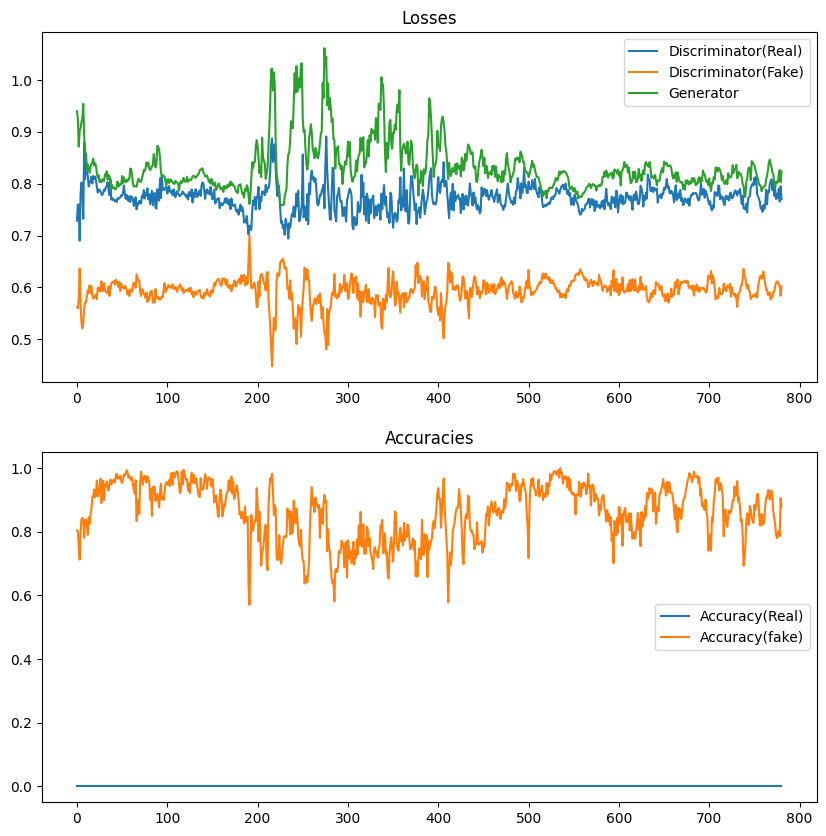

Iteration: 4
[[0.3486801 ]
 [0.4290073 ]
 [0.4535087 ]
 [0.5967132 ]
 [0.47845373]
 [0.42287675]
 [0.33569017]
 [0.39994794]
 [0.38932043]
 [0.5777049 ]]
49.35
47.12
49.78


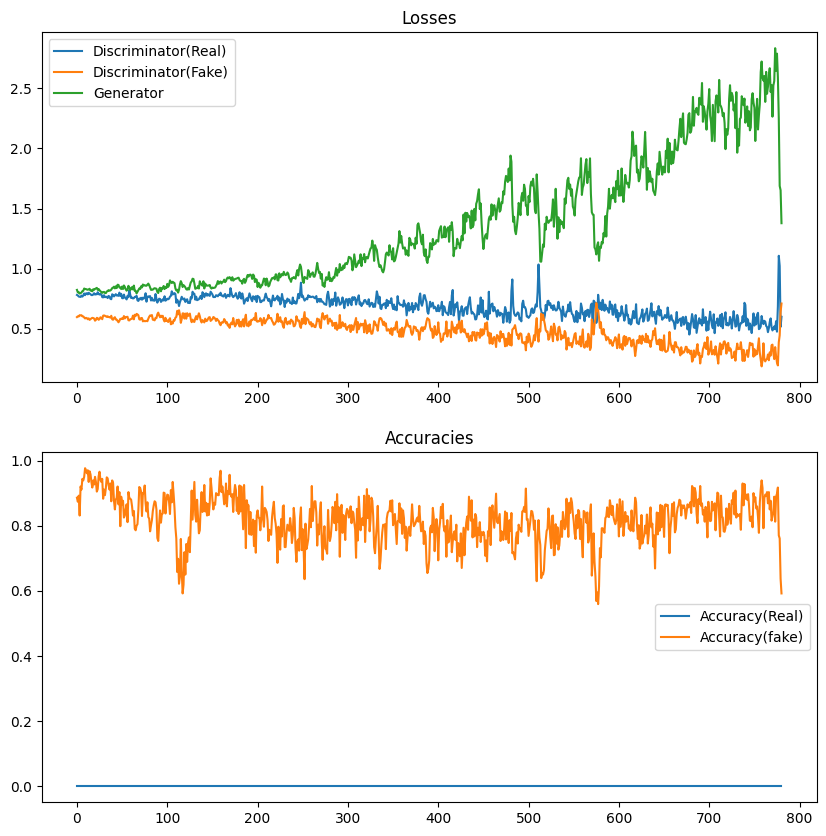

Iteration: 5
[[0.2614458 ]
 [0.32216653]
 [0.32869384]
 [0.45304897]
 [0.36281833]
 [0.470698  ]
 [0.48391187]
 [0.38822103]
 [0.38328665]
 [0.32396188]]
46.03
49.15
50.39


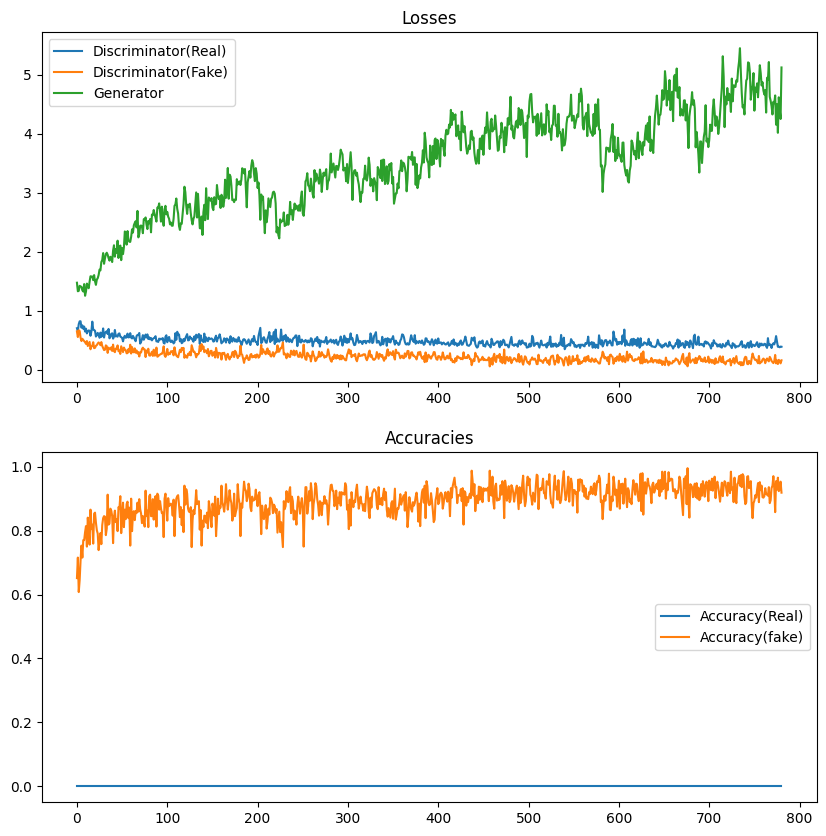

Iteration: 6


In [ ]:
tf.keras.utils.disable_interactive_logging()
gan.train(epochs=10)

In [ ]:
x = gan.generator.predict(np.random.normal(0, 1, (10000, 50)))
print(x.shape)
X1 = np.rint(x[:,0])
X2 = np.rint(x[:,1])
X3 = np.rint(x[:,2])
X4 = np.rint(x[:,3])
X5 = np.rint(x[:,4])
X6 = np.rint(x[:,5])
X7 = np.rint(x[:,6])
X8 = np.rint(x[:,7])
X9 = np.rint(x[:,8])
X10 = np.rint(x[:,9])

print(100*np.count_nonzero((X1 + X6 + X10 ) % 2 - X3) /(10000))
print(100*np.count_nonzero((X4 + X2  + X8) % 2 - X7) /(10000))
print(100*np.count_nonzero(np.abs((X5 + X2 + X8 + X10) % 2 - X9)) /(10000))

In [6]:
print(x[4144])

[[3.4822267e-05]
 [2.9155781e-05]
 [9.9993050e-01]
 [9.9919528e-01]
 [9.9998605e-01]
 [1.6392582e-05]
 [2.3891135e-04]
 [1.6720797e-04]
 [9.9998736e-01]
 [9.9990618e-01]]


In [7]:
print(x[91])

[[1.4649233e-04]
 [9.0704169e-05]
 [9.9942964e-01]
 [8.1439139e-05]
 [9.9990976e-01]
 [2.1102585e-04]
 [2.1519262e-04]
 [6.3550158e-04]
 [9.9992085e-01]
 [9.9988759e-01]]
